In [64]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelWithLMHead
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import classification_report
torch.__version__
from tqdm import tqdm
import numpy as np
from datasets import load_dataset

from transformers import T5Tokenizer, T5ForConditionalGeneration

In [65]:
# wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
# wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
# wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

In [66]:
# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# model = T5ForConditionalGeneration.from_pretrained("t5-small")

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")

In [67]:
dataset = load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

In [145]:
smaller_dataset ={}
for i in tqdm(range(len(dataset['test']))[:5000]):
    sentence, label = dataset['test'][i]["text"], dataset['test'][i]["label"]
    new_label = "positive" if label==1 else "negative"
    smaller_dataset[i] = sentence, new_label

100%|██████████| 5000/5000 [00:00<00:00, 11063.74it/s]


In [146]:
def rank_nlp_dataset_final(dataset, tokenizer, model, prefix,classes=None):

    from cleanlab.rank import get_label_quality_scores
    #### Run the model 

    def get_emotion_probs(text):
        with torch.no_grad():
            enc = tokenizer(prefix+text, return_tensors="pt", padding=True)

            decoder_input_ids = torch.tensor([tokenizer.pad_token_id]).unsqueeze(0)
            
            logits = model(**enc, decoder_input_ids=decoder_input_ids)[0]
#             tokens = torch.argmax(logits, dim=2)
#             emotion = tokenizer.batch_decode(tokens)
        
        return F.softmax(logits,dim=2).squeeze(0)
    
    ## Get pred probs
    pred_probs=[]
    given = []
    encoded_classes = np.array([tokenizer.encode(cls)[:-1][0] for cls in classes])
    for idx in tqdm(range(len(dataset))):
        text,target_emo = dataset[idx]
        if classes is not None:
            probs = get_emotion_probs(text)[0][encoded_classes]
            renorm = probs/sum(probs)
            pred_probs.append(renorm)

            given.append(classes.index(target_emo))
        else:  
            pred_probs.append(get_emotion_probs(text)[0])
            given.append(tokenizer.encode(target_emo)[:-1])

        
    ## Prep for cleanlab
    pred_probs = np.stack(pred_probs)
    given = np.array(given)
    
    ranked_label_issues = get_label_quality_scores(given, pred_probs)
    return ranked_label_issues

In [147]:
rank3 = rank_nlp_dataset_final(smaller_dataset, tokenizer, model, "", classes=["positive", "negative"])

100%|██████████| 5000/5000 [12:11<00:00,  6.83it/s]


In [148]:
np.argsort(rank3)

array([4118, 2688, 3757, ..., 2762, 1428, 1795])

In [149]:
np.sort(rank3)

array([4.4646981e-04, 7.5316016e-04, 8.3282706e-04, ..., 9.9996245e-01,
       9.9996364e-01, 9.9996966e-01], dtype=float32)

In [151]:
dataset_indicies = np.where(rank3>0.99)[0]

In [152]:
dataset_indicies.shape

(3888,)

In [153]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
def lift_at_k(y_true: np.array, y_score: np.array, k: int = 100) -> float:
    """Compute Lift at K evaluation metric"""

    # sort scores
    sort_indices = np.argsort(y_score)

    # compute lift for the top k values
    lift_at_k = y_true[sort_indices][-k:].mean() / y_true.mean()

    return lift_at_k

def compute_metrics(scores: np.array, true_error: np.array, metrics_metadata: dict={}, plot=True) -> dict:
    """
    Uses passed in `scores` of length (N,) and `true_error` mask of length (N,) to calculate metrics for the data.
    
    Parameters
    ----------
    scores : np.ndarray
      Scores per example with values [0,1]. Smaller values indicating examples that are more likeley to have error. 
      Can come directly from calclation like `scores = get_label_quality_scores()`.
    
    true_error : np.ndarray
      Binary mask indicating which examples have error with 1 = error and 0 = no error.
      
    metrics_metadata : dict
      Additional information to append to the calculated metrics dict.
      
    Returns
    -------
    metrics : dict
      A dictionary of computed metrics given `scores` and `true_error`. 
    """
    # compute precision-recall curve using quality scores
    precision, recall, thresholds = precision_recall_curve(true_error, 1 - scores)
    
    # compute prc auc scores
    auprc = auc(recall, precision)
    
    # compute accuracy of detecting errors
    auroc = roc_auc_score(true_error, 1 - scores)

    # lift at K where K = number of errors
    lift_at_num_errors = lift_at_k(true_error, 1 - scores, k=true_error.sum())

    # lift at k=100
    lift_at_100 = lift_at_k(true_error, 1 - scores, k=100)
    
    # feel free to add your own metrics
    metrics = {
        "dataset_num_samples": len(scores),
        "dataset_num_errors": true_error.sum(),
        "auroc": auroc,
        "auprc": auprc,
        "precision": precision,
        "recall": recall,
        "thresholds": thresholds,
        "lift_at_num_errors": lift_at_num_errors,
        "lift_at_100": lift_at_100,
    }
    
    if len(metrics_metadata) > 0:
        metrics = {**metrics_metadata, **metrics}
        
    if plot:
        fpr, tpr, _ = roc_curve(true_error, 1-scores) 
        fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.plot(fpr, tpr)
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.set_title(f"AUROC={auroc}")
        ax2.plot(recall, precision) 
        ax2.set_xlabel("Recall")
        ax2.set_title(f"AUPRC={auprc}")
        ax2.set_ylabel("Precision")
        plt.show()
        
    return metrics

In [154]:
emotions = np.array(["positive", "negative"])

In [155]:
np.random.seed(seed=4)

In [156]:
has_error = []
new_dataset = {}
for idx in range(len(dataset_indicies)):
    source,target = smaller_dataset[idx]
    
    if np.random.random() >0.7:
        target = emotions[emotions!=target][0]
        has_error.append(1)
    else:
        has_error.append(0)
    new_dataset[idx] = source, target
    
    

In [157]:
rank_with_error = rank_nlp_dataset_final(new_dataset, tokenizer, model,"",classes=["positive", "negative"])

  3%|▎         | 121/3888 [06:38<3:26:54,  3.30s/it]


KeyboardInterrupt: 

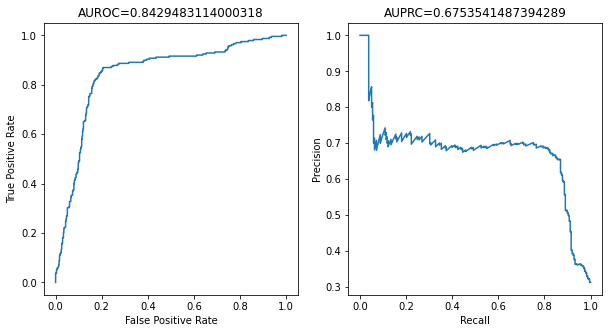

{'dataset_num_samples': 768,
 'dataset_num_errors': 238,
 'auroc': 0.8429483114000318,
 'auprc': 0.6753541487394289,
 'precision': array([0.31398417, 0.31307794, 0.31349206, 0.31390728, 0.31432361,
        0.31474104, 0.31515957, 0.31557923, 0.316     , 0.3164219 ,
        0.31684492, 0.31726908, 0.31769437, 0.31812081, 0.31854839,
        0.31897712, 0.31940701, 0.31983806, 0.32027027, 0.32070365,
        0.32113821, 0.32157395, 0.32201087, 0.32244898, 0.32288828,
        0.32332879, 0.32240437, 0.32284542, 0.32328767, 0.32373114,
        0.32417582, 0.32462173, 0.32369146, 0.32413793, 0.32458564,
        0.32503458, 0.32548476, 0.3259362 , 0.32684284, 0.32775453,
        0.32821229, 0.32867133, 0.32913165, 0.33005618, 0.33052039,
        0.33098592, 0.33004231, 0.33050847, 0.33097595, 0.33144476,
        0.33191489, 0.33238636, 0.33285917, 0.33333333, 0.33380884,
        0.33476395, 0.33524355, 0.33572453, 0.3362069 , 0.33669065,
        0.33717579, 0.33766234, 0.33815029, 0.33863965

In [143]:
compute_metrics(rank_with_error,np.array(has_error))